<a href="https://colab.research.google.com/github/princenishad5471/Projects_Resume_Tnp/blob/main/Economic_and_Political_Event_Impact_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Columns before dropna: ['date', 'open', 'high', 'low', 'close', 'volume', 'return_1d', 'return_3d', 'return_5d', 'volatility_5d', 'volatility_10d', 'volume_change', 'future_return', 'direction']
Shape before dropna: (6, 14)
Head before dropna:
           date          open          high           low         close  \
228  2016-11-08   8540.000000   8559.400391   8480.099609   8543.549805   
388  2017-06-30   9478.500000   9535.799805   9448.750000   9520.900391   
1057 2020-03-24   7848.299805   8036.950195   7511.100098   7801.049805   
1087 2020-05-12   9168.849609   9240.849609   9043.950195   9196.549805   
1535 2022-02-24  16548.900391  16705.250000  16203.250000  16247.950195   

      volume  return_1d  return_3d  return_5d  volatility_5d  volatility_10d  \
228   195700   0.005472   0.006906  -0.009587       0.008451        0.006299   
388   179600   0.001768   0.000999  -0.011329       0.003886        0.003956   
1057  738400   0.025071  -0.055957  -0.130032       0.073091     

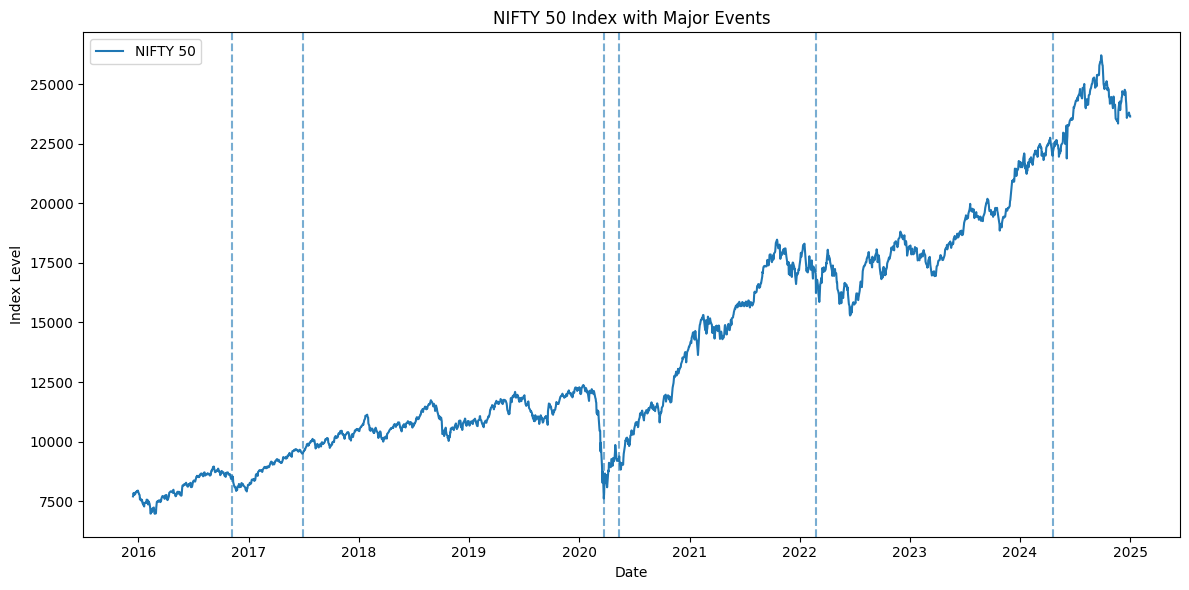

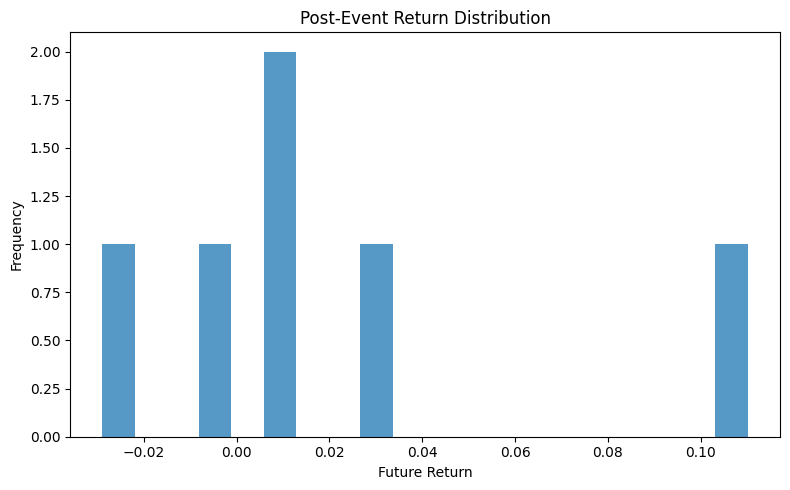


===== NIFTY 50 Model Performance =====
Logistic Regression Accuracy : 0.50
Random Forest RMSE           : 0.0276
XGBoost RMSE                 : 0.0202



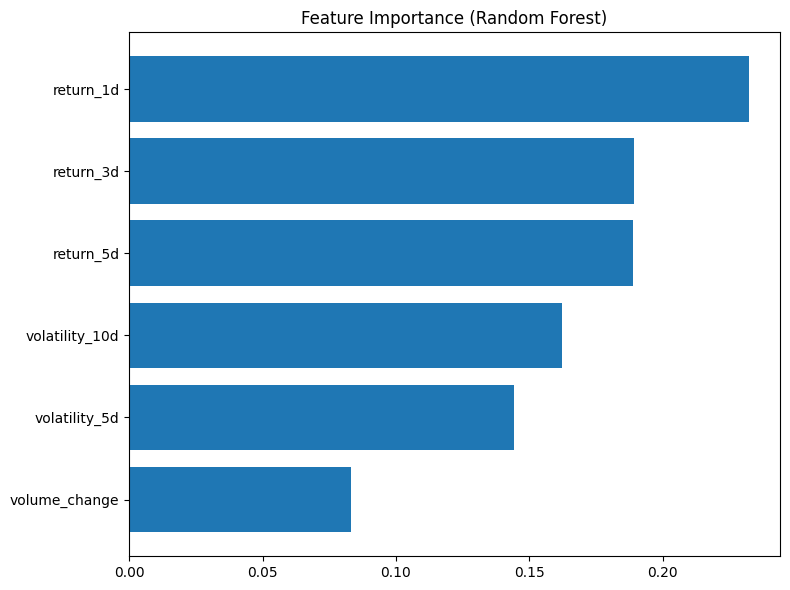

In [1]:
from __future__ import annotations

import warnings
warnings.filterwarnings("ignore")

from dataclasses import dataclass
from datetime import timedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, mean_squared_error

from xgboost import XGBRegressor


# ======================================================
# Configuration
# ======================================================

@dataclass(frozen=True)
class Config:
    ticker: str = "^NSEI"
    start_date: str = "2015-12-01"
    end_date: str = "2025-01-01"
    event_window_days: int = 5
    prediction_horizon_days: int = 3
    test_size: float = 0.3
    random_state: int = 42


CFG = Config()


# ======================================================
# Data Loading
# ======================================================

def load_nifty_data() -> pd.DataFrame:
    df = yf.download(
        CFG.ticker,
        start=CFG.start_date,
        end=CFG.end_date,
        progress=False,
    )

    df.reset_index(inplace=True)
    df.rename(
        columns=
            {
            "Date": "date",
            "Open": "open",
            "High": "high",
            "Low": "low",
            "Close": "close",
            "Volume": "volume",
        },
        inplace=True,
    )

    # Flatten MultiIndex columns if they exist
    df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]

    return df[["date", "open", "high", "low", "close", "volume"]]


# ======================================================
# Indian Economic & Political Events
# ======================================================

def load_event_dates() -> pd.DataFrame:
    return pd.DataFrame(
        {
            "event_date": pd.to_datetime(
                [
                    "2016-11-08",  # Demonetization
                    "2017-07-01",  # GST rollout
                    "2020-03-24",  # COVID lockdown
                    "2020-05-12",  # Atmanirbhar Bharat
                    "2022-02-24",  # Global geopolitical shock
                    "2024-04-19",  # Indian General Elections
                ]
            )
        }
    )


# ======================================================
# Feature Engineering
# ======================================================

def engineer_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    df["return_1d"] = df["close"].pct_change()
    df["return_3d"] = df["close"].pct_change(3)
    df["return_5d"] = df["close"].pct_change(5)

    df["volatility_5d"] = df["return_1d"].rolling(5).std()
    df["volatility_10d"] = df["return_1d"].rolling(10).std()

    df["volume_change"] = df["volume"].pct_change()

    return df.dropna()


# ======================================================
# Event Study Dataset (FIXED — NO AMBIGUOUS BOOLEAN)
# ======================================================

def build_event_dataset(
    stock_df: pd.DataFrame,
    events_df: pd.DataFrame,
) -> pd.DataFrame:
    records = []

    for event_date in events_df["event_date"]:
        window_start = event_date - timedelta(days=CFG.event_window_days)
        window_end = event_date

        window = stock_df[
            (stock_df["date"] >= window_start)
            & (stock_df["date"] <= window_end)
        ]

        if len(window) == 0:
            continue

        snapshot_series = window.iloc[-1].copy()

        future_date = event_date + timedelta(days=CFG.prediction_horizon_days)
        future_prices = stock_df.loc[
            stock_df["date"] >= future_date, "close"
        ]

        if len(future_prices) == 0:
            continue

        # Ensure future_price and snapshot_close are scalar values
        future_price = future_prices.iloc[0].item()
        snapshot_close = snapshot_series["close"].item()

        future_return = (future_price - snapshot_close) / snapshot_close

        snapshot_series["future_return"] = future_return
        snapshot_series["direction"] = 1 if future_return > 0 else 0

        records.append(snapshot_series)

    return pd.DataFrame(records)


# ======================================================
# Visualization
# ======================================================

def plot_price_with_events(stock_df: pd.DataFrame, events_df: pd.DataFrame) -> None:
    plt.figure(figsize=(12, 6))
    plt.plot(stock_df["date"], stock_df["close"], label="NIFTY 50")

    for d in events_df["event_date"]:
        plt.axvline(d, linestyle="--", alpha=0.6)

    plt.title("NIFTY 50 Index with Major Events")
    plt.xlabel("Date")
    plt.ylabel("Index Level")
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_event_return_distribution(event_df: pd.DataFrame) -> None:
    plt.figure(figsize=(8, 5))
    plt.hist(event_df["future_return"], bins=20, alpha=0.75)
    plt.title("Post-Event Return Distribution")
    plt.xlabel("Future Return")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()


def plot_feature_importance(model: RandomForestRegressor, features: list[str]) -> None:
    idx = np.argsort(model.feature_importances_)
    plt.figure(figsize=(8, 6))
    plt.barh(np.array(features)[idx], model.feature_importances_[idx])
    plt.title("Feature Importance (Random Forest)")
    plt.tight_layout()
    plt.show()


# ======================================================
# Modeling
# ======================================================

def train_models(X: pd.DataFrame, y_dir: pd.Series, y_ret: pd.Series) -> None:
    clf = Pipeline(
        [
            ("scaler", StandardScaler()),
            ("model", LogisticRegression(max_iter=1000)),
        ]
    )

    X_train, X_test, y_train, y_test = train_test_split(
        X, y_dir, test_size=CFG.test_size, random_state=CFG.random_state, stratify=y_dir
    )

    clf.fit(X_train, y_train)
    acc = accuracy_score(y_test, clf.predict(X_test))

    rf = RandomForestRegressor(
        n_estimators=300,
        max_depth=6,
        random_state=CFG.random_state,
        n_jobs=-1,
    )

    Xr_train, Xr_test, yr_train, yr_test = train_test_split(
        X, y_ret, test_size=CFG.test_size, random_state=CFG.random_state
    )

    rf.fit(Xr_train, yr_train)
    rf_rmse = mean_squared_error(yr_test, rf.predict(Xr_test)) ** 0.5

    xgb = XGBRegressor(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        random_state=CFG.random_state,
    )

    xgb.fit(Xr_train, yr_train)
    xgb_rmse = mean_squared_error(yr_test, xgb.predict(Xr_test)) ** 0.5

    print("\n===== NIFTY 50 Model Performance =====")
    print(f"Logistic Regression Accuracy : {acc:.2f}")
    print(f"Random Forest RMSE           : {rf_rmse:.4f}")
    print(f"XGBoost RMSE                 : {xgb_rmse:.4f}")
    print("====================================\n")

    plot_feature_importance(rf, list(X.columns))


# ======================================================
# Main
# ======================================================

def main() -> None:
    nifty_df = load_nifty_data()
    events_df = load_event_dates()

    nifty_df = engineer_features(nifty_df)
    event_df = build_event_dataset(nifty_df, events_df)

    # Add print statements as requested
    print(f"Columns before dropna: {event_df.columns.tolist()}")
    print(f"Shape before dropna: {event_df.shape}")
    print(f"Head before dropna:\n{event_df.head()}")

    if event_df.empty:
        raise ValueError("No valid event data generated. Check dates or data range.")

    plot_price_with_events(nifty_df, events_df)
    plot_event_return_distribution(event_df)

    features = [
        "return_1d",
        "return_3d",
        "return_5d",
        "volatility_5d",
        "volatility_10d",
        "volume_change",
    ]

    X = event_df[features]
    y_dir = event_df["direction"]
    y_ret = event_df["future_return"]

    train_models(X, y_dir, y_ret)


if __name__ == "__main__":
    main()